<a href="https://colab.research.google.com/github/tsussi/Cloud-variability-time-frequency/blob/master/t2m_conditional_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### A Denoising Diffusion Model for Super-Resolution Meteorology

This notebook implements denoising diffusion probabilistic modelling (DDPM) to increase resolution of meteorological data through a reverse diffusion process.

The code has been adapted from supplementary material of the article **Diffusion Models for Super-Resolution Microscopy: A Tutorial** by Harshith Bachimanchi and Giovanni Volpe (2025) https://iopscience.iop.org/article/10.1088/2515-7647/ada101

In [ ]:
# Deeplay is a deep learning library in Python that extends PyTorch with
# additional functionalities focused on modularity and reusability. Deeplay
# seeks to address the common issue of rigid and non-reusable modules in PyTorch
# projects by offering a system that allows for easy customization and
# optimization of neural network components. Specifically, it facilitates the
# definition, training, and adjustment of neural networks by introducing dynamic
# modification capabilities for model components after their initial creation.
#
# https://github.com/DeepTrackAI/deeplay
!pip install deeplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch.utils.data import Dataset, random_split
from torch.nn import MaxPool2d
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm # fancy progress bar

import deeplay as dl # torch machine learning framework to define u-nets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load hi-res t2m data
t2m = np.load('/content/drive/MyDrive/t2m_40x40_10k.npy')
# t2m = np.load('/content/t2m_40x40_10k.npy')
t2m_tensor = torch.tensor(t2m, dtype=torch.float32).unsqueeze(1)  # shape: (10000, 1, 40, 40)


In [ ]:
# scale each t2m field to [-1,1]
min_vals = t2m_tensor.view(t2m_tensor.size(0), -1).min(1, keepdim=True)[0].unsqueeze(-1).unsqueeze(-1)
max_vals = t2m_tensor.view(t2m_tensor.size(0), -1).max(1, keepdim=True)[0].unsqueeze(-1).unsqueeze(-1)
t2m_tensor = 2 * (t2m_tensor - min_vals) / (max_vals - min_vals + 1e-8) - 1  # avoid division by zero

# create low-resolution images by maxpooling followed by upscaling.
# hires and low res images have the same size (poorman's method)
pool = MaxPool2d(kernel_size=4)
low_res_tensor = pool(t2m_tensor)  # shape: (10000, 1, 10, 10)
low_res_tensor = low_res_tensor.repeat_interleave(4, dim=2).repeat_interleave(4, dim=3)

print(t2m_tensor.shape, low_res_tensor.shape, sep='\n')

torch.Size([10000, 1, 40, 40])
torch.Size([10000, 1, 40, 40])


In [ ]:
# DataSet class to return pairs of hi-res and low-res images
class T2mDataset(Dataset):
    def __init__(self, low_res, high_res):
        self.low_res = low_res
        self.high_res = high_res
    def __len__(self):
        return len(self.low_res)
    def __getitem__(self, idx):
        return self.low_res[idx], self.high_res[idx]

# make full dataset
full_dataset = T2mDataset(low_res_tensor, t2m_tensor)

In [ ]:
# 80/20 train-test split into training and testing data set
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [ ]:
print(len(train_dataset), len(test_dataset))

8000 2000


(np.float64(-0.5), np.float64(39.5), np.float64(39.5), np.float64(-0.5))

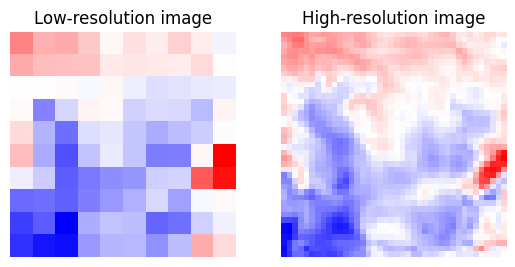

In [ ]:
# plot an example pair or low-res and hi-res image
i_plt = np.random.choice(len(train_dataset))
low_res_image, high_res_image = train_dataset[i_plt]
_, axs = plt.subplots(1, 2)
axs[0].imshow(low_res_image.squeeze(), cmap="bwr")
axs[0].set_title("Low-resolution image")
axs[0].axis("off")
axs[1].imshow(high_res_image.squeeze(), cmap="bwr")
axs[1].set_title("High-resolution image")
axs[1].axis("off")

In [ ]:
# do we have a gpu available?
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [ ]:
# Denoising diffusion probabilstic model (DDPM) class
class DDPM:
    def __init__(self, noise_steps=1000,
                 beta_start=1e-4, beta_end=0.02,
                 img_size=40, device=device):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.img_size = img_size
    # noise schedule (linear)
    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    # forward diffusion process: calculate x(t) from x(0) clean image based on timestep
    def forward_diffusion(self, x0, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x0)
        #return clean image with noise and noise to be generated
        return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise
    # reverse diffusion process: calculate x(0) from x(T) using a denoising model
    def reverse_diffusion(self, model, n_images, n_channels,
                          position_encoding_dim, position_encoding_function,
                          save_time_steps=None, input_image=None):
        with torch.no_grad():
          #random noise
            x = torch.randn((n_images, n_channels, self.img_size, self.img_size)).to(self.device)
            denoised_images = []
            #reverse in time from T to 0
            for i in tqdm(reversed(range(0, self.noise_steps)),
                          desc="U-Net inference", total=self.noise_steps):
                t = (torch.ones(n_images) * i).long()
                t_pos_enc = position_encoding_function(t.unsqueeze(1), position_encoding_dim).to(self.device)
                inp = torch.cat((input_image.to(self.device), x), dim=1)
                predicted_noise = model(inp, t_pos_enc)
                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
                x = (1 / torch.sqrt(alpha) * (x - ((1 - alpha)
                    / torch.sqrt(1 - alpha_bar)) * predicted_noise)
                    + torch.sqrt(1-alpha) * noise)
                if i in save_time_steps:
                    denoised_images.append(x)
            denoised_images = torch.stack(denoised_images)
            denoised_images = denoised_images.swapaxes(0, 1)
            return denoised_images

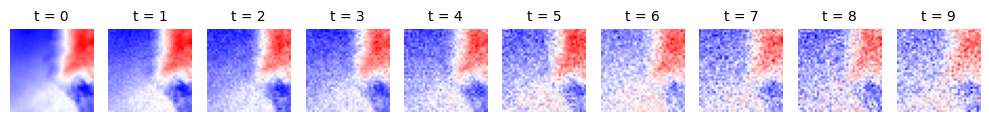

In [ ]:
# visualise example images from forward diffusion process

# initialise ddpm object
n_img = 10
diffusion = DDPM(noise_steps=n_img, img_size=40, beta_start=0.0001, beta_end=0.02)

# sample a high-res image
i_plt = np.random.choice(len(train_dataset))
_, high_res_image = train_dataset[i_plt]

# generate noisy images using the forward_diffusion() function
noisy_images = []
time_steps = torch.arange(0, n_img)
for i in range(n_img):
    noisy_image, noise = diffusion.forward_diffusion(
        x0 = high_res_image[None, ...].to(device),
        t = torch.tensor([time_steps[i]]).to(device))
    noisy_images.append(noisy_image)

# visualise
#noisy version of the image
fig, axs = plt.subplots(1, len(time_steps), figsize=(10, 2))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(noisy_images[i].cpu().numpy().squeeze(), cmap="bwr")
    ax.set_title(f"t = {time_steps[i]}", fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# function to encode time via positional encoding
def positional_encoding(t, enc_dim):
    inv_freq = 1.0 / (10000 ** (torch.arange(0, enc_dim, 2).float() / enc_dim)).to(t.device)
    pos_enc_a = torch.sin(t.repeat(1, enc_dim // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, enc_dim // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

Text(0.5, 1.0, 'Sinusoidal position encodings')

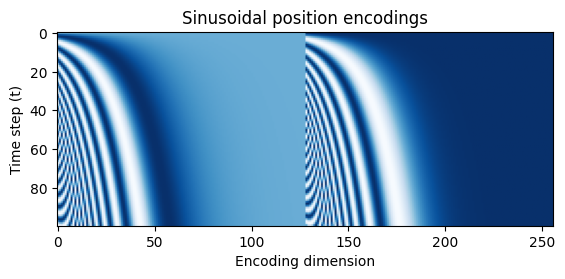

In [ ]:
# calculate positional encodings for 100 time steps
position_encoding_dim = 256
pos_encs = []
for i in range(0, 100):
    t = torch.tensor([i])
    pos_enc = positional_encoding(t, position_encoding_dim)
    pos_encs.append(pos_enc.squeeze())
pos_encs = torch.stack(pos_encs)

# visualise position encoding
plt.imshow(pos_encs.cpu().numpy(), cmap="Blues")
plt.xlabel("Encoding dimension")
plt.ylabel("Time step (t)")
plt.title("Sinusoidal position encodings")

In [ ]:
# define epcilon model (the u-net model) used for conditional noise estimation

position_encoding_dim = 256
unet = dl.AttentionUNet(
    in_channels=2,
    channels=[32, 64, 128],
    base_channels=[256, 256],
    channel_attention=[False, False, False],
    out_channels=1,
    position_embedding_dim=position_encoding_dim,
)
unet.build()
unet.to(device)

AttentionUNet(
  (encoder): UNetEncoder(
    (blocks): LayerList(
      (0): FeatureIntegrationModule(
        (blocks): LayerList(
          (0): Block(
            (layer): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
            (activation): GELU(approximate='none')
          )
          (1): Block(
            (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
            (activation): GELU(approximate='none')
          )
        )
        (res_block): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1))
        (feed_forward_position_embedding): Linear(in_features=256, out_features=32, bias=True)
      )
      (1): FeatureIntegrationModule(
        (blocks): LayerList(
          (0): Block(
            (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (normalization)

In [ ]:
# data loaders
from torch.utils.data import DataLoader

# make data loaders to use during training
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# loss function
criterion = torch.nn.MSELoss()

# optimiser
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

# define diffusion class
noise_steps = 2000
diffusion = DDPM(
    noise_steps=noise_steps,
    img_size=40,
    beta_start=1e-6,
    beta_end=0.01,
)

In [ ]:
# set up the data for super-resolution training. this function returns
# x_t: concatenation of noisy target image at time t, and corresponding low-res (input) image
# t: positional encoding of diffusion time step
# noise: noise that was added to target image
def prepare_data(input_image, target_image, device=device):
    batch_size = input_image.shape[0]
    input_image = input_image.to(device)
    target_image = target_image.to(device)
    t = torch.randint(low=0, high=noise_steps, size=(batch_size,)).to(device)
    x_t, noise = diffusion.forward_diffusion(target_image, t)
    x_t = torch.cat((input_image, x_t), dim=1)
    t = positional_encoding(t.unsqueeze(1), position_encoding_dim)
    return x_t.to(device), t.to(device), noise.to(device)

Starting Epoch 1/20

Batch 1/125: Train loss: 1.0224
Batch 21/125: Train loss: 0.3345
Batch 41/125: Train loss: 0.1456
Batch 61/125: Train loss: 0.1435
Batch 81/125: Train loss: 0.1150
Batch 101/125: Train loss: 0.1083
Batch 121/125: Train loss: 0.0719
Train loss: 0.2104, Time taken: 0:00:03.009284


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 211.63it/s]


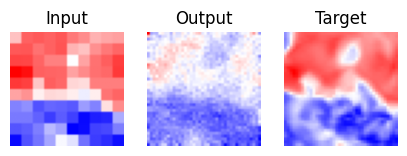

Starting Epoch 2/20

Batch 1/125: Train loss: 0.0892
Batch 21/125: Train loss: 0.0732
Batch 41/125: Train loss: 0.0599
Batch 61/125: Train loss: 0.0718
Batch 81/125: Train loss: 0.0414
Batch 101/125: Train loss: 0.0450
Batch 121/125: Train loss: 0.0705
Train loss: 0.0673, Time taken: 0:00:02.168996


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 213.24it/s]


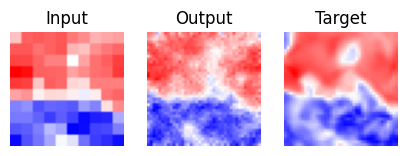

Starting Epoch 3/20

Batch 1/125: Train loss: 0.0760
Batch 21/125: Train loss: 0.0831
Batch 41/125: Train loss: 0.0733
Batch 61/125: Train loss: 0.0671
Batch 81/125: Train loss: 0.0377
Batch 101/125: Train loss: 0.0862
Batch 121/125: Train loss: 0.0509
Train loss: 0.0487, Time taken: 0:00:02.177356


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 213.03it/s]


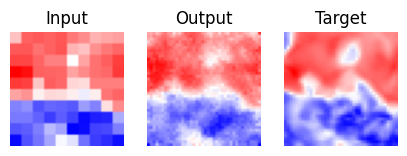

Starting Epoch 4/20

Batch 1/125: Train loss: 0.0403
Batch 21/125: Train loss: 0.0233
Batch 41/125: Train loss: 0.0486
Batch 61/125: Train loss: 0.0460
Batch 81/125: Train loss: 0.0373
Batch 101/125: Train loss: 0.0682
Batch 121/125: Train loss: 0.0687
Train loss: 0.0434, Time taken: 0:00:02.179973


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 212.07it/s]


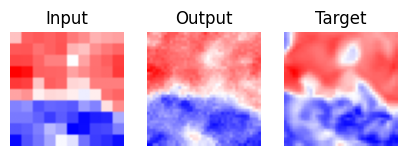

Starting Epoch 5/20

Batch 1/125: Train loss: 0.0329
Batch 21/125: Train loss: 0.0209
Batch 41/125: Train loss: 0.0323
Batch 61/125: Train loss: 0.0218
Batch 81/125: Train loss: 0.0309
Batch 101/125: Train loss: 0.0137
Batch 121/125: Train loss: 0.0292
Train loss: 0.0397, Time taken: 0:00:02.179593


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 210.47it/s]


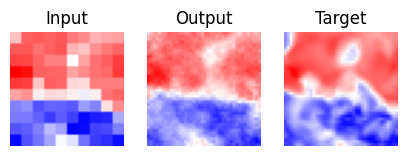

Starting Epoch 6/20

Batch 1/125: Train loss: 0.0433
Batch 21/125: Train loss: 0.0322
Batch 41/125: Train loss: 0.0491
Batch 61/125: Train loss: 0.0352
Batch 81/125: Train loss: 0.0406
Batch 101/125: Train loss: 0.0266
Batch 121/125: Train loss: 0.0346
Train loss: 0.0358, Time taken: 0:00:02.187438


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 211.02it/s]


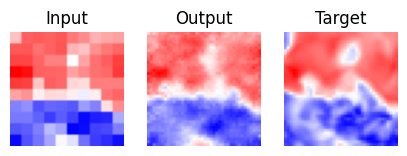

Starting Epoch 7/20

Batch 1/125: Train loss: 0.0242
Batch 21/125: Train loss: 0.0265
Batch 41/125: Train loss: 0.0309
Batch 61/125: Train loss: 0.0305
Batch 81/125: Train loss: 0.0423
Batch 101/125: Train loss: 0.0294
Batch 121/125: Train loss: 0.0231
Train loss: 0.0340, Time taken: 0:00:02.189498


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 209.28it/s]


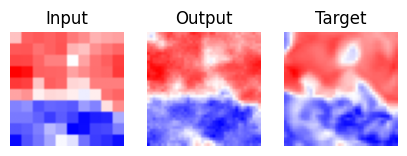

Starting Epoch 8/20

Batch 1/125: Train loss: 0.0265
Batch 21/125: Train loss: 0.0184
Batch 41/125: Train loss: 0.0326
Batch 61/125: Train loss: 0.0181
Batch 81/125: Train loss: 0.0322
Batch 101/125: Train loss: 0.0215
Batch 121/125: Train loss: 0.0197
Train loss: 0.0305, Time taken: 0:00:02.194856


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 212.63it/s]


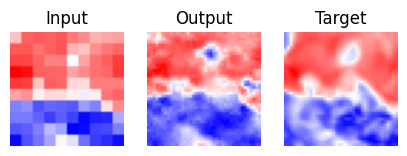

Starting Epoch 9/20

Batch 1/125: Train loss: 0.0326
Batch 21/125: Train loss: 0.0307
Batch 41/125: Train loss: 0.0395
Batch 61/125: Train loss: 0.0374
Batch 81/125: Train loss: 0.0283
Batch 101/125: Train loss: 0.0410
Batch 121/125: Train loss: 0.0195
Train loss: 0.0310, Time taken: 0:00:02.197941


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 210.47it/s]


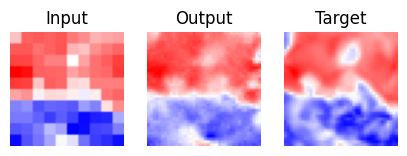

Starting Epoch 10/20

Batch 1/125: Train loss: 0.0198
Batch 21/125: Train loss: 0.0480
Batch 41/125: Train loss: 0.0276
Batch 61/125: Train loss: 0.0524
Batch 81/125: Train loss: 0.0299
Batch 101/125: Train loss: 0.0236
Batch 121/125: Train loss: 0.0346
Train loss: 0.0308, Time taken: 0:00:02.195879


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 210.46it/s]


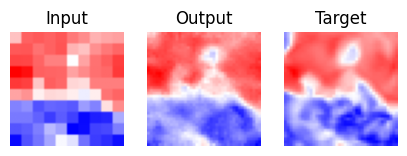

Starting Epoch 11/20

Batch 1/125: Train loss: 0.0505
Batch 21/125: Train loss: 0.0351
Batch 41/125: Train loss: 0.0353
Batch 61/125: Train loss: 0.0254
Batch 81/125: Train loss: 0.0455
Batch 101/125: Train loss: 0.0133
Batch 121/125: Train loss: 0.0308
Train loss: 0.0306, Time taken: 0:00:02.200422


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 209.99it/s]


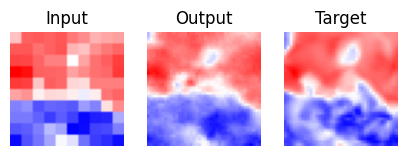

Starting Epoch 12/20

Batch 1/125: Train loss: 0.0204
Batch 21/125: Train loss: 0.0207
Batch 41/125: Train loss: 0.0317
Batch 61/125: Train loss: 0.0352
Batch 81/125: Train loss: 0.0538
Batch 101/125: Train loss: 0.0137
Batch 121/125: Train loss: 0.0226
Train loss: 0.0301, Time taken: 0:00:02.200338


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 211.50it/s]


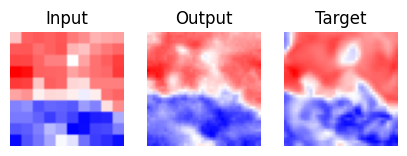

Starting Epoch 13/20

Batch 1/125: Train loss: 0.0325
Batch 21/125: Train loss: 0.0345
Batch 41/125: Train loss: 0.0130
Batch 61/125: Train loss: 0.0199
Batch 81/125: Train loss: 0.0454
Batch 101/125: Train loss: 0.0305
Batch 121/125: Train loss: 0.0279
Train loss: 0.0291, Time taken: 0:00:02.200513


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 211.82it/s]


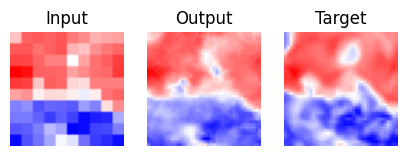

Starting Epoch 14/20

Batch 1/125: Train loss: 0.0198
Batch 21/125: Train loss: 0.0404
Batch 41/125: Train loss: 0.0117
Batch 61/125: Train loss: 0.0573
Batch 81/125: Train loss: 0.0217
Batch 101/125: Train loss: 0.0357
Batch 121/125: Train loss: 0.0300
Train loss: 0.0285, Time taken: 0:00:02.202724


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 210.24it/s]


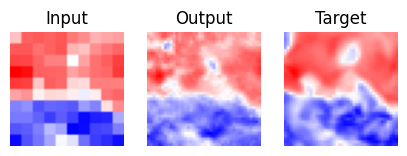

Starting Epoch 15/20

Batch 1/125: Train loss: 0.0389
Batch 21/125: Train loss: 0.0107
Batch 41/125: Train loss: 0.0189
Batch 61/125: Train loss: 0.0780
Batch 81/125: Train loss: 0.0265
Batch 101/125: Train loss: 0.0140
Batch 121/125: Train loss: 0.0414
Train loss: 0.0291, Time taken: 0:00:02.201240


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 210.94it/s]


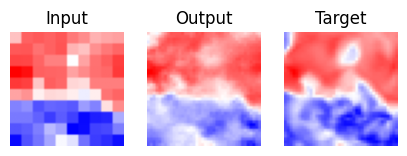

Starting Epoch 16/20

Batch 1/125: Train loss: 0.0498
Batch 21/125: Train loss: 0.0282
Batch 41/125: Train loss: 0.0356
Batch 61/125: Train loss: 0.0213
Batch 81/125: Train loss: 0.0481
Batch 101/125: Train loss: 0.0277
Batch 121/125: Train loss: 0.0103
Train loss: 0.0287, Time taken: 0:00:02.206491


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 209.99it/s]


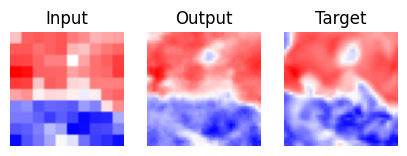

Starting Epoch 17/20

Batch 1/125: Train loss: 0.0362
Batch 21/125: Train loss: 0.0438
Batch 41/125: Train loss: 0.0162
Batch 61/125: Train loss: 0.0234
Batch 81/125: Train loss: 0.0216
Batch 101/125: Train loss: 0.0639
Batch 121/125: Train loss: 0.0501
Train loss: 0.0292, Time taken: 0:00:02.209859


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 209.58it/s]


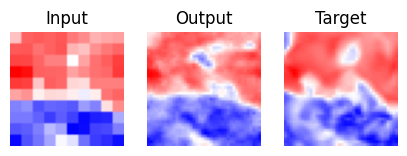

Starting Epoch 18/20

Batch 1/125: Train loss: 0.0340
Batch 21/125: Train loss: 0.0228
Batch 41/125: Train loss: 0.0250
Batch 61/125: Train loss: 0.0156
Batch 81/125: Train loss: 0.0335
Batch 101/125: Train loss: 0.0283
Batch 121/125: Train loss: 0.0229
Train loss: 0.0258, Time taken: 0:00:02.212494


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 210.83it/s]


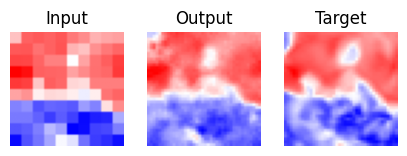

Starting Epoch 19/20

Batch 1/125: Train loss: 0.0324
Batch 21/125: Train loss: 0.0249
Batch 41/125: Train loss: 0.0111
Batch 61/125: Train loss: 0.0350
Batch 81/125: Train loss: 0.0198
Batch 101/125: Train loss: 0.0167
Batch 121/125: Train loss: 0.0359
Train loss: 0.0290, Time taken: 0:00:02.217900


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 209.19it/s]


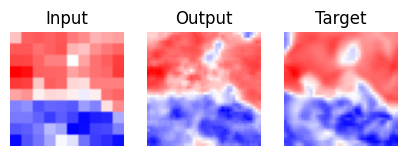

Starting Epoch 20/20

Batch 1/125: Train loss: 0.0167
Batch 21/125: Train loss: 0.0271
Batch 41/125: Train loss: 0.0330
Batch 61/125: Train loss: 0.0118
Batch 81/125: Train loss: 0.0252
Batch 101/125: Train loss: 0.0272
Batch 121/125: Train loss: 0.0214
Train loss: 0.0267, Time taken: 0:00:02.221823


U-Net inference: 100%|██████████| 2000/2000 [00:09<00:00, 208.89it/s]


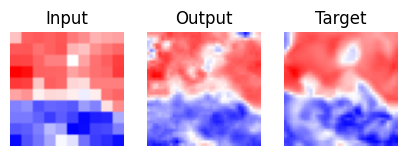

In [ ]:
# main training loop
# after each epoch generate some example images generated by the denoising diffusion model
import time
from datetime import timedelta

epochs = 20
train_loss = []

for epoch in range(epochs):
    start_time = time.time()
    num_batches = len(train_loader)
    print(f"Starting Epoch {epoch + 1}/{epochs}" + "\n")
    unet.train()

    running_loss = 0.0
    for batch_idx, (input_images, target_images) in enumerate(train_loader, start=0):
        x_t, t, noise = prepare_data(input_images, target_images)

        outputs = unet(x=x_t, t=t)
        optimizer.zero_grad()
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}: " \
                  + f"Train loss: {loss.item():.4f}")
        running_loss += loss.item()

    train_loss.append(running_loss / num_batches)
    end_time = time.time()

    print(f"Train loss: {train_loss[-1]:.4f}, " +
          f"Time taken: {timedelta(seconds=end_time - start_time)}")

    unet.eval()

    # generate reverse diffusion images to inspect model in current epoch
    n_images = 1
    test_input_images, test_target_images = next(iter(test_loader))
    num_batches = len(test_loader)
    test_input_images = test_input_images.to(device)
    test_target_images = test_target_images.to(device)
    generated_images = diffusion.reverse_diffusion(
        model=unet,
        n_channels=1,
        n_images=n_images,
        position_encoding_dim=position_encoding_dim,
        position_encoding_function=positional_encoding,
        input_image=test_input_images[:n_images],
        save_time_steps=[0])

    fig = plt.figure(figsize=(5, 8))
    for i in range(n_images):
        image_diff_trajectory = generated_images[i]

        low_res_image = test_input_images[i]
        generated_high_res_image = image_diff_trajectory[-1]
        target_high_res_image = test_target_images[i]

        plt.subplot(n_images, 3, i * 3 + 1)
        plt.title("Input")
        plt.imshow(low_res_image.permute(1, 2, 0).cpu().numpy(), cmap="bwr")
        plt.axis("off")

        plt.subplot(n_images, 3, i * 3 + 2)
        plt.title("Output")
        plt.imshow(generated_high_res_image.permute(1, 2, 0).cpu().numpy(), cmap="bwr")
        plt.axis("off")

        plt.subplot(n_images, 3, i * 3 + 3)
        plt.title("Target")
        plt.imshow(target_high_res_image.permute(1, 2, 0).cpu().numpy(), cmap="bwr")
        plt.axis("off")

    plt.show()
    plt.close(fig)

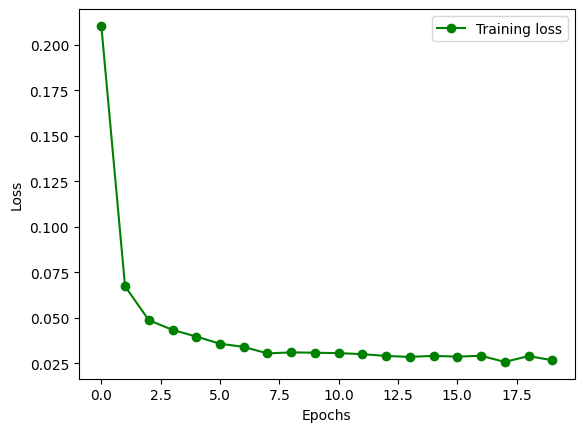

In [ ]:
plt.figure()
plt.plot(train_loss, "g-o", label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# generate reverse diffusion images to inspect model in current epoch
test_input_images, test_target_images = next(iter(test_loader))
test_input_images = test_input_images.to(device)
test_target_images = test_target_images.to(device)
n_images = len(test_input_images)
generated_images = diffusion.reverse_diffusion(
    model=unet,
    n_channels=1,
    n_images=n_images,
    position_encoding_dim=position_encoding_dim,
    position_encoding_function=positional_encoding,
    input_image=test_input_images[:n_images],
    save_time_steps=[0])


U-Net inference: 100%|██████████| 2000/2000 [00:11<00:00, 168.73it/s]


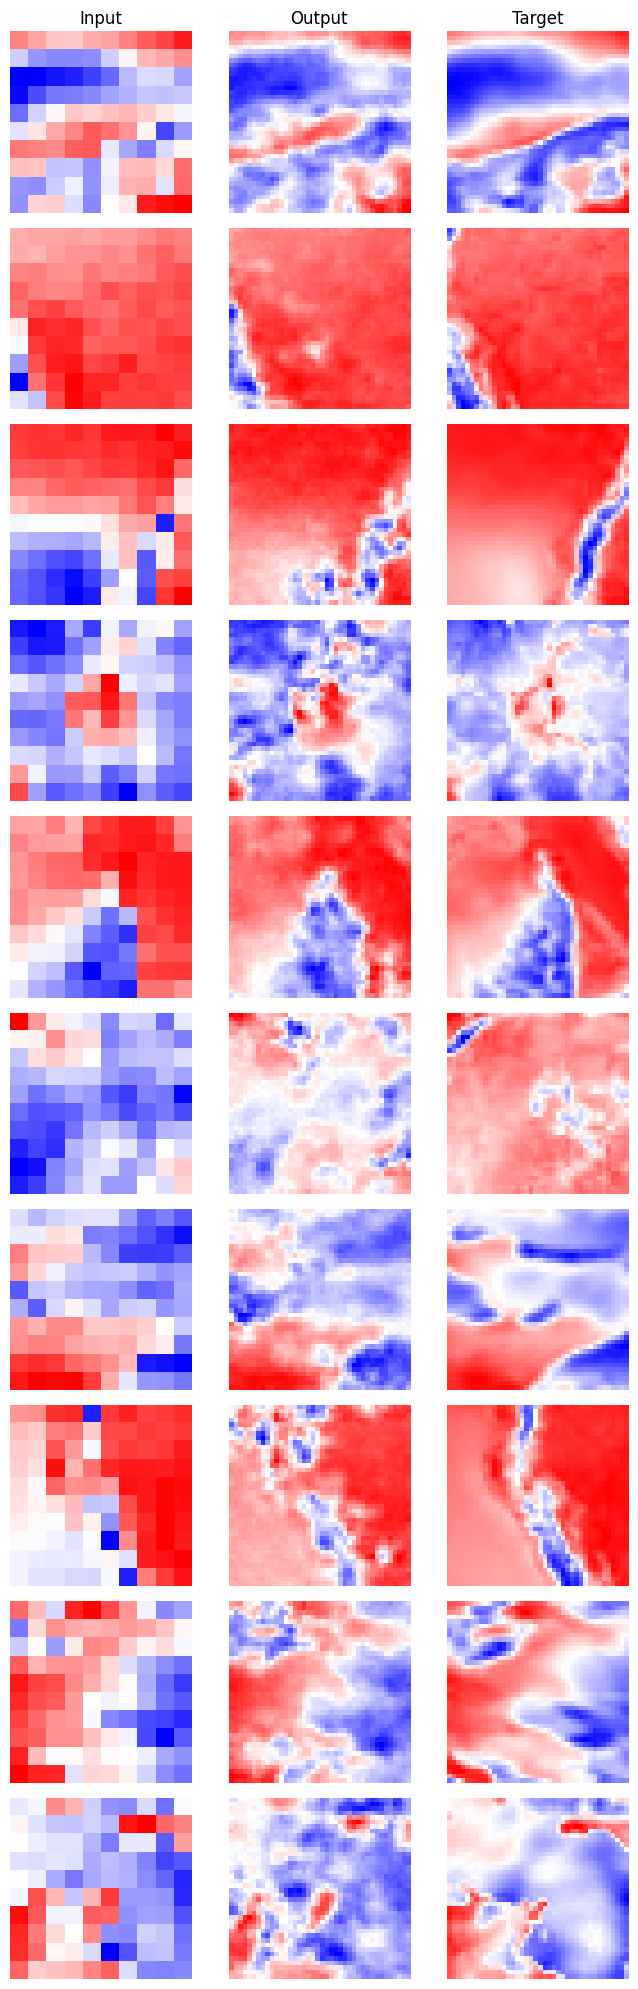

In [ ]:
import random
n_plt = 10
fig, axs = plt.subplots(n_plt, 3, figsize=(7, 20))
for i, j in enumerate(random.sample(range(n_images), n_plt)):
    image_diff_trajectory = generated_images[j]
    generated_high_res_image = image_diff_trajectory[-1].cpu().numpy().squeeze()
    low_res_image = test_input_images[j].cpu().numpy().squeeze()
    target_high_res_image = test_target_images[j].cpu().numpy().squeeze()

    axs[i,0].imshow(low_res_image, cmap="bwr")
    axs[i,0].axis("off")
    axs[i,1].imshow(generated_high_res_image, cmap="bwr")
    axs[i,1].axis("off")
    axs[i,2].imshow(target_high_res_image, cmap="bwr")
    axs[i,2].axis("off")

axs[0,0].set_title("Input")
axs[0,1].set_title("Output")
axs[0,2].set_title("Target")
plt.tight_layout()

In [ ]:
for i,j in enumerate(random.sample(range(10), 5)):
  print(i,j)